# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
# Data Manipulation
import pandas as pd
import numpy as np
import pycountry_convert as pc

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

from geopy.exc import GeocoderTimedOut
from geopy.geocoders import Nominatim

# Encoding categorical variables
from sklearn.preprocessing import LabelEncoder
from scipy.stats import zscore
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Data Splitting
from sklearn.model_selection import train_test_split

# Machine Learning Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Suppressing Warnings
import warnings
warnings.filterwarnings('ignore')

### Loading the Data

In [3]:
df = pd.read_csv("data/customer_booking.csv", 
                 encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [5]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [6]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [7]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

### Other Neccessary Data Conversion

**'sales_channel' Encoding**

In [8]:
df['sales_channel'].unique()

array(['Internet', 'Mobile'], dtype=object)

In [9]:
# Create a new column 'sales_channel_Internet' and set it to 1 if 'sales_channel' is 'Internet', 0 otherwise
df['sales_channel_Internet'] = (df['sales_channel'] == 'Internet').astype(int)

# Create a new column 'sales_channel_Mobile' and set *it to 1 if 'sales_channel' is 'Mobile', 0 otherwise
df['sales_channel_Mobile'] = (df['sales_channel'] == 'Mobile').astype(int)

# Drop the original 'sales_channel' column
df.drop(columns=['sales_channel'], 
        inplace=True)

**'trip_type' Encoding**

In [10]:
df['trip_type'].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [11]:
# Create a new column 'trip_type_RoundTrip' and set it to 1 if 'trip_type' is 'RoundTrip', 0 otherwise
df['trip_type_RoundTrip'] = (df['trip_type'] == 'RoundTrip').astype(int)

# Create a new column 'trip_type_CircleTrip' and set it to 1 if 'trip_type' is 'CircleTrip', 0 otherwise
df['trip_type_CircleTrip'] = (df['trip_type'] == 'CircleTrip').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df['trip_type_OneWay'] = (df['trip_type'] == 'OneWay').astype(int)

# Drop the original 'trip_type' column
df.drop(columns=['trip_type'], 
        inplace=True)

**Checking the unique count of 'booking_origin')**

In [12]:
unique_count = df['booking_origin'].nunique()
print("Number of unique values:", unique_count)

Number of unique values: 104


In [34]:
unique_observations = df.drop_duplicates(subset=['booking_origin'])
unique_observations.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_RoundTrip,trip_type_CircleTrip,trip_type_OneWay
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1,0,1,0,0
2,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1,0,1,0,0
10,2,185,25,14,2,AKLDEL,United Kingdom,1,1,1,5.52,0,1,0,1,0,0
19,1,351,17,3,7,AKLHGH,China,0,0,0,5.07,0,1,0,1,0,0
21,1,21,88,9,3,AKLICN,South Korea,1,0,1,6.62,0,1,0,1,0,0


**Make a copy of the data, df and name as df_copy for country conversion**

In [17]:
df_copy = df.copy()
df_copy.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_RoundTrip,trip_type_CircleTrip,trip_type_OneWay
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1,0,1,0,0
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0,1,0,0
2,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1,0,1,0,0
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0,1,0,0
4,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0,1,0,0


**Create a country conversion function**

In [35]:
def convert(row):
    # Handle the case where 'booking_origin' is '(not set)'
    if row.booking_origin == '(not set)':
        return None  # or return a default value if needed

    # Convert the country name to country code
    try:
        cn_code = pc.country_name_to_country_alpha2(row.booking_origin, cn_name_format='default')
    except KeyError:
        return None  # or return a default value if needed

    # Convert cn_code to continent code
    try:
        conti_code = pc.country_alpha2_to_continent_code(cn_code)
    except KeyError:
        return None  # or return a default value if needed

    # Convert continent code to continent name
    try:
        conti_name = pc.convert_continent_code_to_continent_name(conti_code)
    except KeyError:
        return None  # or return a default value if needed

    return conti_name

# Create a new 'Continent' column
df_copy['Continent'] = df_copy.apply(convert, axis=1)

In [37]:
df_copy.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,sales_channel_Mobile,trip_type_RoundTrip,trip_type_CircleTrip,trip_type_OneWay,Continent
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,5.52,0,1,0,1,0,0,Oceania
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,5.52,0,1,0,1,0,0,Oceania
2,2,243,22,17,3,AKLDEL,India,1,1,0,5.52,0,1,0,1,0,0,Asia
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,5.52,0,1,0,1,0,0,Oceania
4,2,68,22,15,3,AKLDEL,India,1,0,1,5.52,0,1,0,1,0,0,Asia


**Check unique continents in df_copy**

In [33]:
unique_continents = df_copy['Continent'].unique()
unique_continents

array(['Oceania', 'Asia', 'Europe', 'Africa', None, 'North America',
       'South America'], dtype=object)

### Continent Encoding

In [39]:
# Create a new column 'trip_type_RoundTrip' and set it to 1 if 'trip_type' is 'RoundTrip', 0 otherwise
df_copy['Continent_Oceania'] = (df_copy['Continent'] == 'Oceania').astype(int)

# Create a new column 'trip_type_CircleTrip' and set it to 1 if 'trip_type' is 'CircleTrip', 0 otherwise
df_copy['Continent_Asia'] = (df_copy['Continent'] == 'Asia').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df_copy['Continent_Europe'] = (df_copy['Continent'] == 'Europe').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df_copy['Continent_Africa'] = (df_copy['Continent'] == 'Africa').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df_copy['Continent_None'] = (df_copy['Continent'] == 'None').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df_copy['Continent_North_America'] = (df_copy['Continent'] == 'North America').astype(int)

# Create a new column 'trip_type_OneWay' and set it to 1 if 'trip_type' is 'OneWay', 0 otherwise
df_copy['Continent_South America'] = (df_copy['Continent'] == 'South America').astype(int)

# Drop the original 'trip_type' column
#df_copy.drop(columns=['Continent'], 
        #inplace=True)
    
df_copy.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,...,trip_type_CircleTrip,trip_type_OneWay,Continent,Continent_Oceania,Continent_Asia,Continent_Europe,Continent_Africa,Continent_None,Continent_North_America,Continent_South America
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,...,0,0,Oceania,1,0,0,0,0,0,0
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,...,0,0,Oceania,1,0,0,0,0,0,0
2,2,243,22,17,3,AKLDEL,India,1,1,0,...,0,0,Asia,0,1,0,0,0,0,0
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,...,0,0,Oceania,1,0,0,0,0,0,0
4,2,68,22,15,3,AKLDEL,India,1,0,1,...,0,0,Asia,0,1,0,0,0,0,0


In [40]:
df_copy.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,...,trip_type_RoundTrip,trip_type_CircleTrip,trip_type_OneWay,Continent_Oceania,Continent_Asia,Continent_Europe,Continent_Africa,Continent_None,Continent_North_America,Continent_South America
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,3.814420,0.668780,0.296960,0.427140,7.277561,0.149560,...,0.989940,0.002320,0.007740,0.379200,0.593780,0.011560,0.001380,0.0,0.010500,0.000820
std,1.020165,90.451378,33.88767,5.41266,1.992792,0.470657,0.456923,0.494668,1.496863,0.356643,...,0.099795,0.048111,0.087637,0.485193,0.491131,0.106895,0.037123,0.0,0.101931,0.028624
min,1.000000,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,4.670000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,2.000000,0.000000,0.000000,0.000000,5.620000,0.000000,...,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,4.000000,1.000000,0.000000,0.000000,7.570000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,5.000000,1.000000,1.000000,1.000000,8.830000,0.000000,...,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000
max,9.000000,867.000000,778.00000,23.00000,7.000000,1.000000,1.000000,1.000000,9.500000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

### Visualizing the New Data Frame After Data Conversion

In [41]:
df_copy.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,...,trip_type_CircleTrip,trip_type_OneWay,Continent,Continent_Oceania,Continent_Asia,Continent_Europe,Continent_Africa,Continent_None,Continent_North_America,Continent_South America
0,2,262,19,7,6,AKLDEL,New Zealand,1,0,0,...,0,0,Oceania,1,0,0,0,0,0,0
1,1,112,20,3,6,AKLDEL,New Zealand,0,0,0,...,0,0,Oceania,1,0,0,0,0,0,0
2,2,243,22,17,3,AKLDEL,India,1,1,0,...,0,0,Asia,0,1,0,0,0,0,0
3,1,96,31,4,6,AKLDEL,New Zealand,0,0,1,...,0,0,Oceania,1,0,0,0,0,0,0
4,2,68,22,15,3,AKLDEL,India,1,0,1,...,0,0,Asia,0,1,0,0,0,0,0


### Checking for Outliers in the Dataset

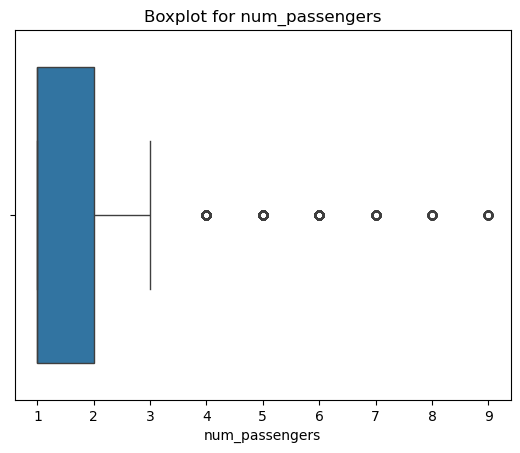

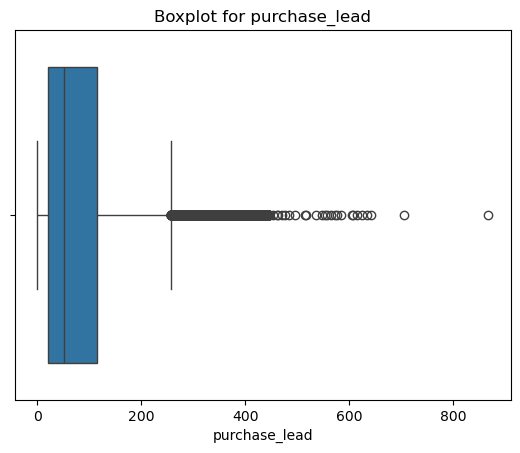

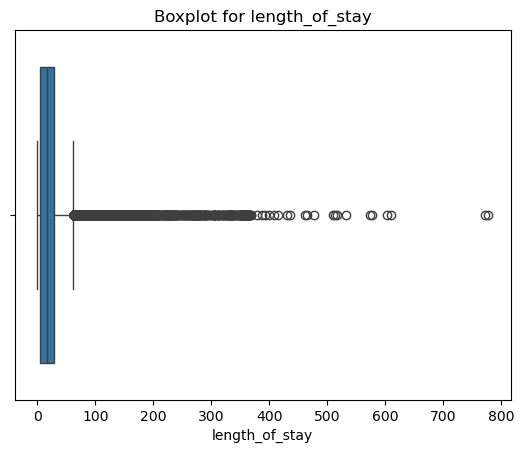

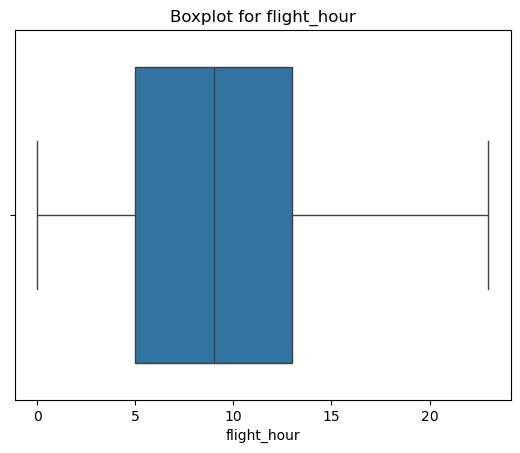

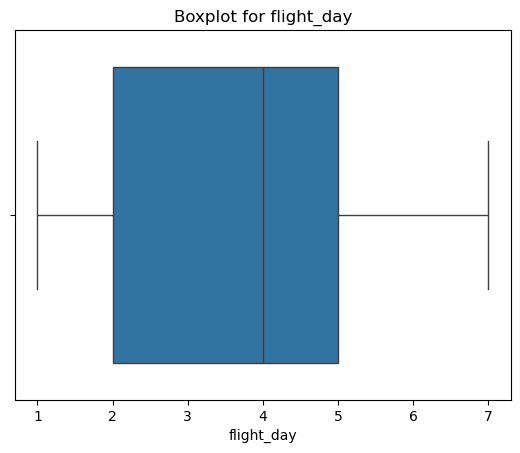

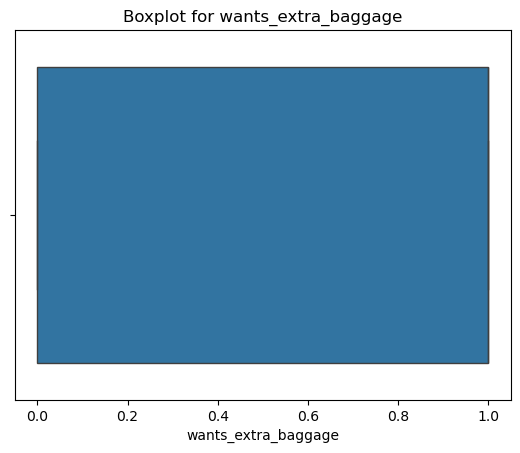

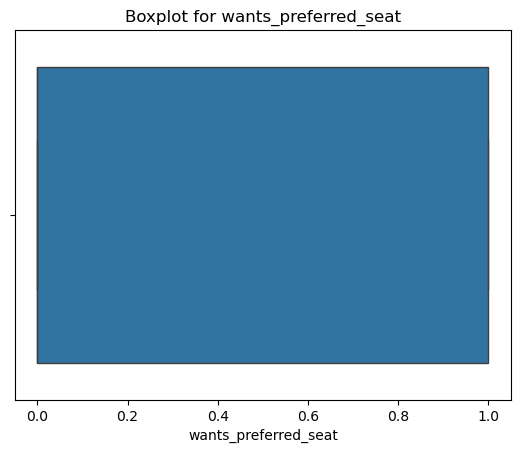

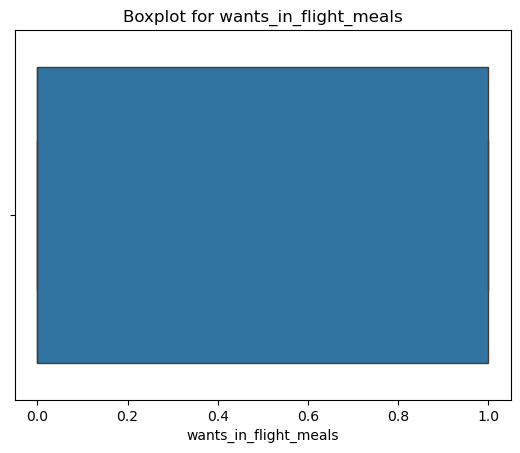

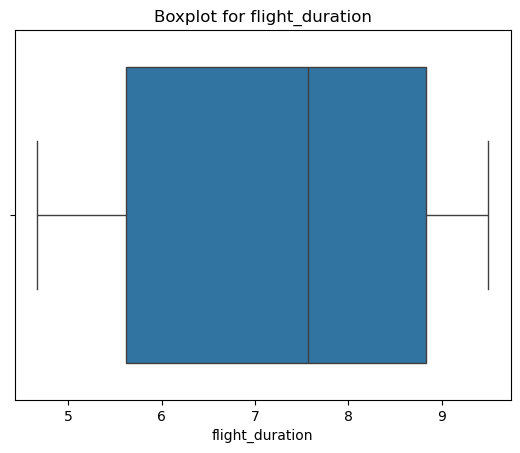

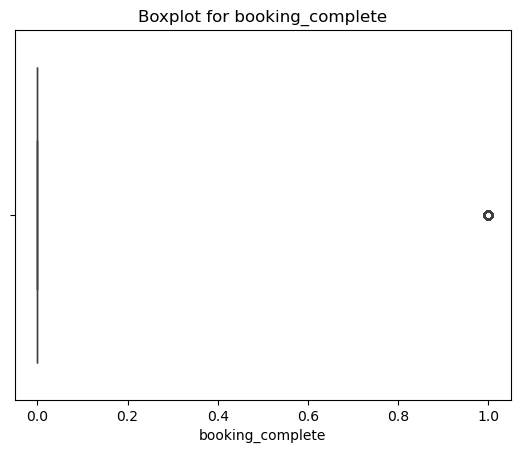

In [42]:
numerical_features = df_copy.select_dtypes(include=['int64', 
                                               'float64']).columns

# Create boxplots for all numerical features
for feature in numerical_features:
    sns.boxplot(x=df_copy[feature])
    plt.title(f'Boxplot for {feature}')
    plt.show()

Based on the observed boxplot above, it is apparent that the features 'purchase_lead' and 'length_of_stay' exhibit a considerable number of outliers. Consequently, there is a need for a more thorough examination of these columns.

### Examining 'num_passengers', 'purchase_lead', and 'length_of_stay', Columns

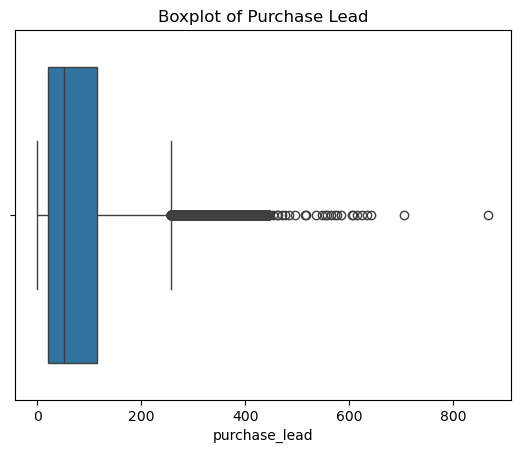

In [43]:
sns.boxplot(data=df_copy, x='purchase_lead')
plt.title('Boxplot of Purchase Lead')
plt.show()

In [44]:
df_copy['num_passengers'].unique()

array([2, 1, 3, 4, 6, 5, 7, 9, 8], dtype=int64)

### Using Scatterplot and Z-Score to Calculate and Visualize Potential Outliers

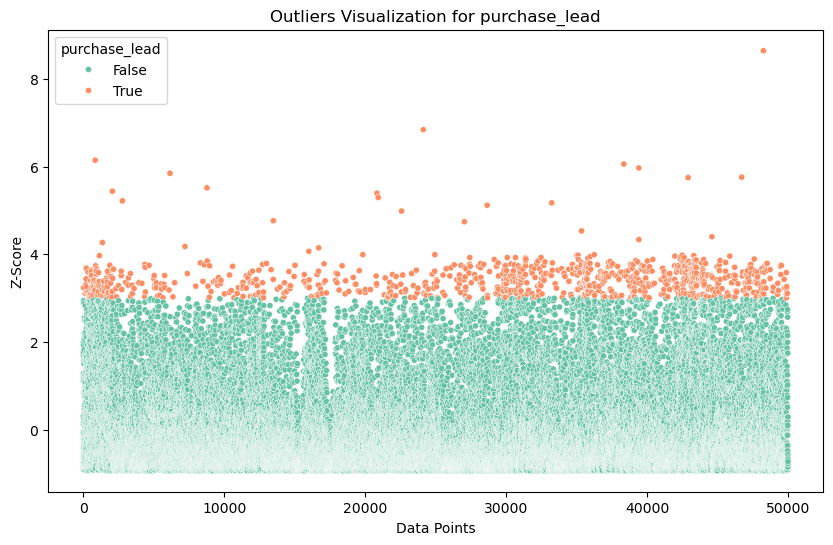

In [45]:
purchase_lead_column = df_copy['purchase_lead']

# Calculate z-scores for the 'purchase_lead' column
z_scores = zscore(purchase_lead_column)

# Create a scatter plot to visualize z-scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_copy.index, 
                y=z_scores, 
                hue=(z_scores > 3) | (z_scores < -3), 
                palette="Set2", s=20)
plt.title('Outliers Visualization for purchase_lead')
plt.xlabel('Data Points')
plt.ylabel('Z-Score')
plt.show()

### Identifying Potential Outliers: Z-Scores Greater Than 3

In [47]:
purchase_lead_column = df_copy['purchase_lead']

# Calculate z-scores for the 'purchase_lead' column
z_scores = zscore(purchase_lead_column)

# Define a threshold for considering values as outliers (3 standard deviations)
threshold = 3

# Identify outliers based on the threshold
outliers_mask = (z_scores > threshold) | (z_scores < -threshold)

# Print rows corresponding to outliers
outliers_df = df_copy[outliers_mask]
print("Rows with outliers:")
print(outliers_df)

Rows with outliers:
       num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
9                   1            378              30           12           7   
135                 4            366              17           16           7   
162                 1            384              18            5           4   
190                 1            396              23            9           1   
195                 1            380              21           21           4   
...               ...            ...             ...          ...         ...   
49882               5            376               6            9           7   
49893               2            357               6           15           4   
49894               5            364               6            6           2   
49916               2            380               6            6           7   
49955               2            366               6            2           2   

       

### Top 20 Countries Based on Average Purchase Lead Time

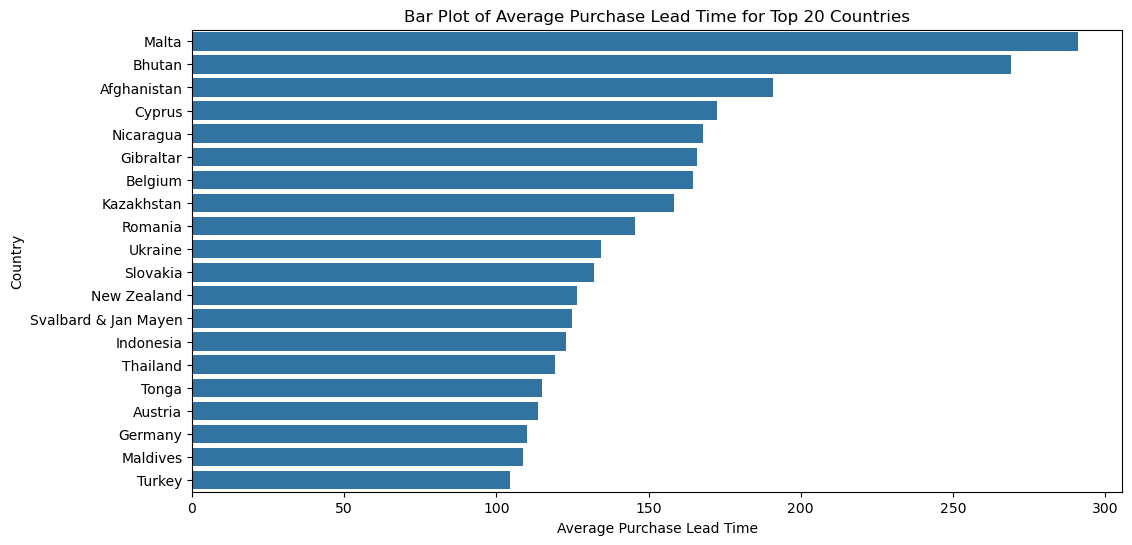

In [48]:
# Get the top 20 countries based on the highest average purchase_lead counts in descending order
top_countries = df_copy.groupby('booking_origin')['purchase_lead'].mean().nlargest(20).index

# Filter the data for the top 20 countries
df_top_countries = df_copy[df_copy['booking_origin'].isin(top_countries)]

# Set up the figure
plt.figure(figsize=(12, 6))

# Bar plot to visualize average purchase_lead by country for the top 20 countries
sns.barplot(x='purchase_lead', 
            y='booking_origin', 
            data=df_top_countries, 
            ci=None, 
            order=top_countries)

# Add title and labels
plt.title('Bar Plot of Average Purchase Lead Time for Top 20 Countries')
plt.xlabel('Average Purchase Lead Time')
plt.ylabel('Country')

# Show the plot
plt.show()

**Average Purchase Lead Time Across Top 20 Countries:**
- Malta emerges as the leading country in terms of average purchase lead time among the top 20, closely followed by Bhutan and Afghanistan. Notably, Turkey exhibits the least average purchase lead time in this group, showcasing a range of booking behaviors across these diverse countries.

### Analysis of Days Between Traveling Date and Booking Date by Continent

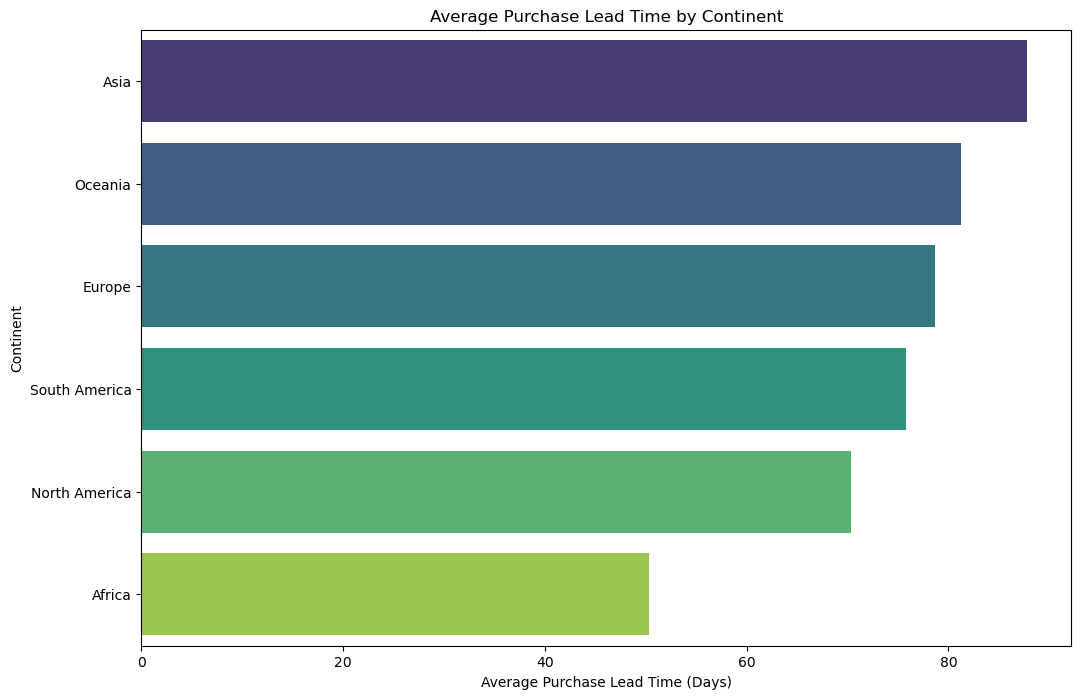

In [86]:
# Get the order of continents based on the highest average purchase_lead counts in descending order
continent_order = df_copy.groupby('Continent')['purchase_lead'].mean().nlargest(len(df_copy['Continent'].unique())).index

# Set up the figure
plt.figure(figsize=(12, 8))

# Bar plot to visualize average purchase_lead by continent
sns.barplot(x='purchase_lead', 
            y='Continent', 
            data=df_copy, 
            ci=None, 
            order=continent_order,  # Specify the order
            palette='viridis')

# Add title and labels
plt.title('Average Purchase Lead Time by Continent')
plt.xlabel('Average Purchase Lead Time (Days)')
plt.ylabel('Continent')

# Display the plot
plt.show()

Upon examination of the bar plot, it is evident that the continent with the highest average number of days between traveling date and booking date is **Asia** closely followed by **Oceania** and **Europe**. **South-America**, and **North_America** also exhibits a notable duration, while **Africa** records the least duration on the chart.

*This analysis provides insights into the distribution of days between traveling date and booking date across various continents.*

###  Number of Entries by Continent

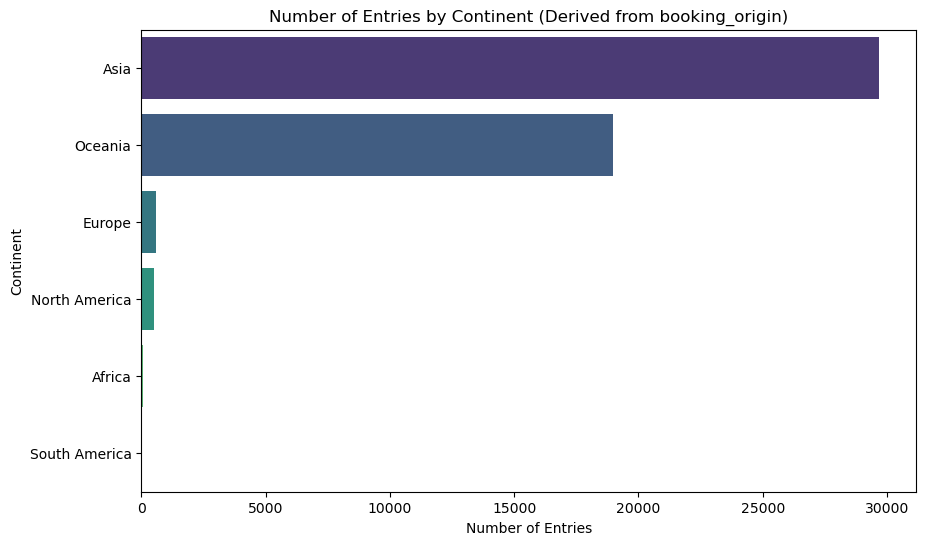

In [50]:
# Count the number of entries for each continent
continent_counts = df_copy['Continent'].value_counts()

# Plot the bar plot with Continent on the vertical axis
plt.figure(figsize=(10, 6))
sns.barplot(x=continent_counts.values, 
            y=continent_counts.index, 
            palette='viridis')
plt.title('Number of Entries by Continent (Derived from booking_origin)')
plt.xlabel('Number of Entries')
plt.ylabel('Continent')
plt.show()

**Key Observations**

**Regional Dominance:**
- Asia emerges as the leading market for flight bookings, boasting over 3000 entries.
Oceania follows closely behind with approximately 2000 entries, indicating significant demand in these regions.

**Limited Engagement in Established Markets:**
- Europe and North America, while representing established markets, exhibit comparatively lower participation, reflected in a minimal number of entries.

**Untapped Potential in Emerging Markets:**
- Africa and South America are currently underrepresented, presenting untapped potential and opportunities for market growth and expansion in these regions.

### Examining 'length_of_stay' for Potential Outliers

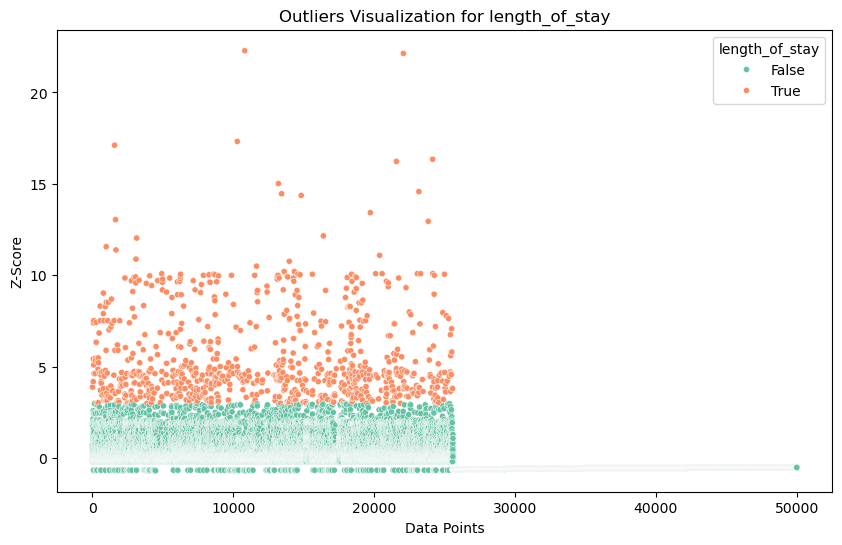

In [52]:
length_of_stay_column = df_copy['length_of_stay']

# Calculate z-scores for the 'length_of_stay' column
z_scores_length_of_stay = zscore(length_of_stay_column)

# Create a scatter plot to visualize z-scores
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df_copy.index, 
                y=z_scores_length_of_stay, 
                hue=(z_scores_length_of_stay > 3) | (z_scores_length_of_stay < -3), 
                palette="Set2", s=20)
plt.title('Outliers Visualization for length_of_stay')
plt.xlabel('Data Points')
plt.ylabel('Z-Score')
plt.show()

In [53]:
# Define a threshold for considering values as outliers (e.g., 3 standard deviations)
threshold_length_of_stay = 3

# Identify outliers based on the threshold
outliers_mask_length_of_stay = (z_scores_length_of_stay > threshold_length_of_stay) | (z_scores_length_of_stay < -threshold_length_of_stay)

# Print rows corresponding to outliers in 'length_of_stay'
outliers_df_length_of_stay = df_copy[outliers_mask_length_of_stay]
print("Rows with outliers in 'length_of_stay':")
print(outliers_df_length_of_stay)

Rows with outliers in 'length_of_stay':
       num_passengers  purchase_lead  length_of_stay  flight_hour  flight_day  \
18                  1             67             155            8           7   
69                  1              2             165            3           1   
73                  1            198             207           10           7   
83                  1             31             274           10           2   
104                 1             93             196            8           2   
...               ...            ...             ...          ...         ...   
25472               1             78             178           23           3   
25500               1             20             263           23           7   
25515               1             23             220           12           1   
25530               1             12             153           11           3   
25572               1              3             152           13    

### Verifying the Total Unique Count for 'route'

In [54]:
# Sum of unique counts across multiple columns
columns_of_interest = ['route']
total_unique_count = df_copy[columns_of_interest].nunique().sum()
total_unique_count  

799

### Discovering the Relationship Among Variables through Correlation Matrix Analysis

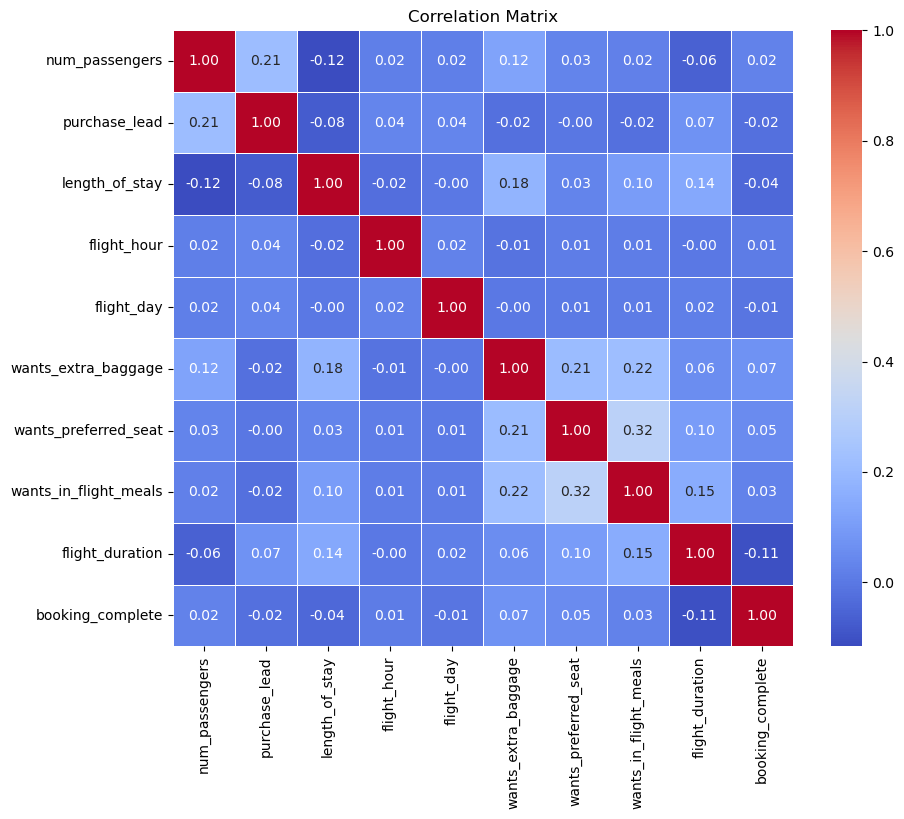

In [57]:
numerical_columns = df_copy.select_dtypes(include=['int64', 
                                              'float64']).columns
correlation_matrix = df_copy[numerical_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, 
            annot=True, 
            cmap='coolwarm', 
            fmt=".2f", 
            linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

### Correlation Analysis
**Positive Correlations:**

- num_passengers has a positive correlation with purchase_lead (0.21) and wants_extra_baggage (0.12).
- length_of_stay is positively correlated with wants_extra_baggage (0.18) and wants_in_flight_meals (0.10).
- flight_day and flight_hour have a positive correlation of 0.02.

**Negative Correlations:**

- length_of_stay has a negative correlation with num_passengers (-0.12).
- purchase_lead is negatively correlated with length_of_stay (-0.08).
- flight_duration is negatively correlated with num_passengers (-0.06) and booking_complete (-0.11).

**Weak Correlations:**

- Many variables show weak correlations (close to zero) with each other.

In [66]:
df_new = df_copy.copy()
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_passengers           50000 non-null  int64  
 1   purchase_lead            50000 non-null  int64  
 2   length_of_stay           50000 non-null  int64  
 3   flight_hour              50000 non-null  int64  
 4   flight_day               50000 non-null  int64  
 5   route                    50000 non-null  object 
 6   booking_origin           50000 non-null  object 
 7   wants_extra_baggage      50000 non-null  int64  
 8   wants_preferred_seat     50000 non-null  int64  
 9   wants_in_flight_meals    50000 non-null  int64  
 10  flight_duration          50000 non-null  float64
 11  booking_complete         50000 non-null  int64  
 12  sales_channel_Internet   50000 non-null  int32  
 13  sales_channel_Mobile     50000 non-null  int32  
 14  trip_type_RoundTrip   

### Dropping Unneccessary Columns

In [67]:
# Drop columns 'route', 'booking_origin', 'Continent'
df_new.drop(['route', 
             'booking_origin', 
             'Continent'], 
            axis=1, 
            inplace=True)

# Display DataFrame info
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 22 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num_passengers           50000 non-null  int64  
 1   purchase_lead            50000 non-null  int64  
 2   length_of_stay           50000 non-null  int64  
 3   flight_hour              50000 non-null  int64  
 4   flight_day               50000 non-null  int64  
 5   wants_extra_baggage      50000 non-null  int64  
 6   wants_preferred_seat     50000 non-null  int64  
 7   wants_in_flight_meals    50000 non-null  int64  
 8   flight_duration          50000 non-null  float64
 9   booking_complete         50000 non-null  int64  
 10  sales_channel_Internet   50000 non-null  int32  
 11  sales_channel_Mobile     50000 non-null  int32  
 12  trip_type_RoundTrip      50000 non-null  int32  
 13  trip_type_CircleTrip     50000 non-null  int32  
 14  trip_type_OneWay      

### Feature Engineering

**Separating Predictors and Target Variable**

In [68]:
# Predictors (X): All columns except 'booking_complete'
X = df_new.drop('booking_complete', 
            axis=1)

# Response (y): 'booking_complete' column
y = df_new['booking_complete']

In [69]:
X

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_day,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,sales_channel_Internet,...,trip_type_RoundTrip,trip_type_CircleTrip,trip_type_OneWay,Continent_Oceania,Continent_Asia,Continent_Europe,Continent_Africa,Continent_None,Continent_North_America,Continent_South America
0,2,262,19,7,6,1,0,0,5.52,1,...,1,0,0,1,0,0,0,0,0,0
1,1,112,20,3,6,0,0,0,5.52,1,...,1,0,0,1,0,0,0,0,0,0
2,2,243,22,17,3,1,1,0,5.52,1,...,1,0,0,0,1,0,0,0,0,0
3,1,96,31,4,6,0,0,1,5.52,1,...,1,0,0,1,0,0,0,0,0,0
4,2,68,22,15,3,1,0,1,5.52,1,...,1,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,2,27,6,9,6,1,0,1,5.62,1,...,1,0,0,1,0,0,0,0,0,0
49996,1,111,6,4,7,0,0,0,5.62,1,...,1,0,0,1,0,0,0,0,0,0
49997,1,24,6,22,6,0,0,1,5.62,1,...,1,0,0,1,0,0,0,0,0,0
49998,1,15,6,11,1,1,0,1,5.62,1,...,1,0,0,1,0,0,0,0,0,0


**Label Encoding for Categorical Columns: 'route' and 'booking_origin'**

In [70]:
# Create a LabelEncoder object
# label_encoder = LabelEncoder()

# Apply label encoding to the 'route' and 'booking_origin' columns
# X['route_encoded'] = label_encoder.fit_transform(X['route'])
# X['booking_origin_encoded'] = label_encoder.fit_transform(X['booking_origin'])

# Drop the original 'route' and 'booking_origin' columns
# X.drop(['route', 
        # 'booking_origin'], 
       # axis=1, 
       # inplace=True)

**Standardizing All Numerical Columns Using StandardScaler**

In [71]:
# Create a StandardScaler object
# scaler = StandardScaler()

# Standardize all columns
# X = scaler.fit_transform(X)

**Train-Test Split of the Dataset: 80% Training and 20% Testing**

In [72]:
# Splitting the dataset into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, 
                                                    random_state=42)

# Display the shape of the training and testing sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((40000, 21), (10000, 21), (40000,), (10000,))

### Modelling

In [73]:
# Training the model
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

**Model Prediction and Evaluation**

In [74]:
# Predicting on the test set
y_pred = rf.predict(X_test)

# Evaluating the model
print('Classification Report:\n', 
      classification_report(y_test, 
                            y_pred))
print('Confusion Matrix:\n', 
      confusion_matrix(y_test, 
                       y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.44      0.07      0.12      1480

    accuracy                           0.85     10000
   macro avg       0.65      0.53      0.52     10000
weighted avg       0.80      0.85      0.80     10000

Confusion Matrix:
 [[8394  126]
 [1381   99]]


In [76]:
# Classification Report
classification_rep = classification_report(y_test, 
                                           y_pred, 
                                           output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()

In [77]:
classification_df

,precision,recall,f1-score,support
0,0.858721,0.985211,0.917628,8520.0000
1,0.440000,0.066892,0.116129,1480.0000
accuracy,0.849300,0.849300,0.849300,0.8493
macro avg,0.649361,0.526052,0.516878,10000.0000
weighted avg,0.796750,0.849300,0.799006,10000.0000


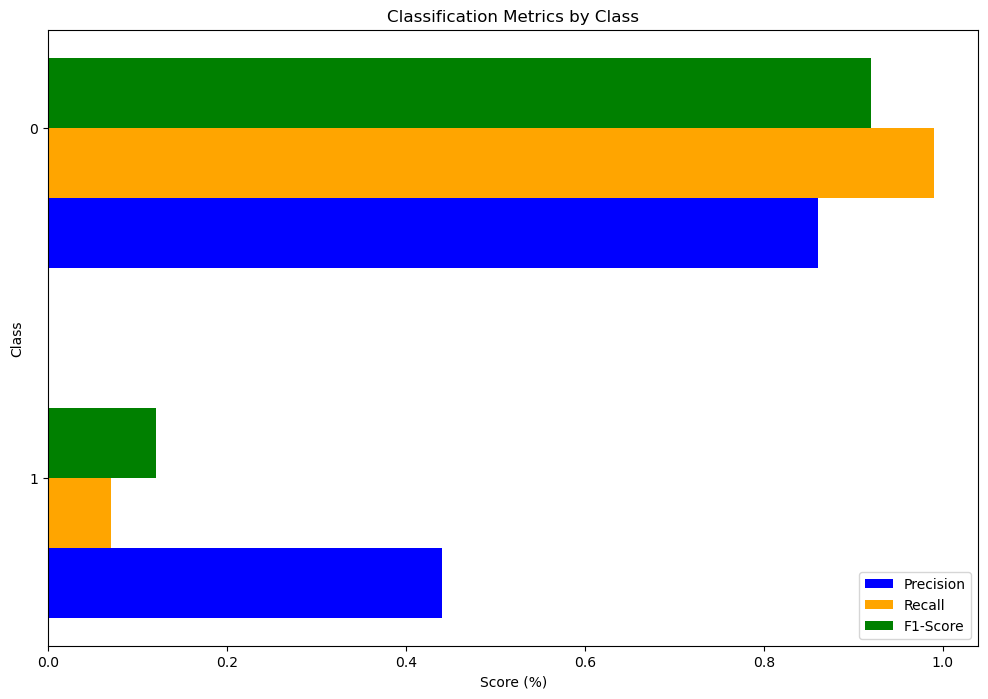

In [80]:
# Predicting on the test set
y_pred = rf.predict(X_test)

# Displaying the classification report
report_str = classification_report(y_test, y_pred)


# Parsing the classification report string
report_data = []
lines = report_str.split('\n')
for line in lines[2:-5]:
    row = line.split()
    report_data.append(row)

# Extracting class names and metrics
class_names = [row[0] for row in report_data]
precision = [float(row[1]) for row in report_data]
recall = [float(row[2]) for row in report_data]
f1_score = [float(row[3]) for row in report_data]

# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Creating a horizontal bar plot for precision, recall, f1-score, and accuracy
plt.figure(figsize=(12, 8))

# Sort data in ascending order of precision
sorted_indices = np.argsort(precision)
class_names_sorted = [class_names[i] for i in sorted_indices]
precision_sorted = [precision[i] for i in sorted_indices]
recall_sorted = [recall[i] for i in sorted_indices]
f1_score_sorted = [f1_score[i] for i in sorted_indices]

bar_width = 0.2
index = np.arange(len(class_names_sorted))

plt.barh(index, 
         precision_sorted, 
         color='blue', 
         label='Precision', 
         height=bar_width)
plt.barh(index + bar_width, 
         recall_sorted, 
         color='orange',
         label='Recall', 
         height=bar_width)
plt.barh(index + 2*bar_width, 
         f1_score_sorted, 
         color='green', 
         label='F1-Score', 
         height=bar_width)

# Adding labels and title
plt.xlabel('Score (%)')
plt.ylabel('Class')
plt.title('Classification Metrics by Class')
plt.yticks(index + 1.5*bar_width, class_names_sorted)
plt.legend()

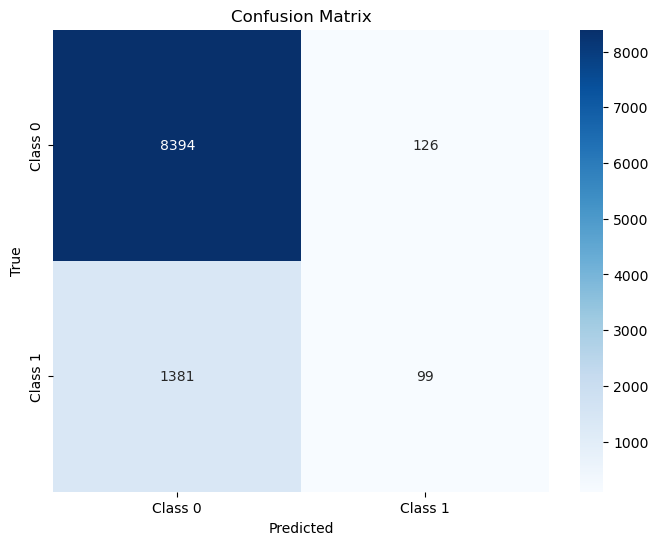

In [81]:
# Creating a confusion matrix heatmap
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            xticklabels=['Class 0', 'Class 1'], 
            yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Consufion Matrix**

**True Positive (TP):** 
- 99 instances were correctly predicted as class 1.

**True Negative (TN):** 
- 8394 instances were correctly predicted as class 0.

**False Positive (FP):** 
- 126 instances were incorrectly predicted as class 1.

**False Negative (FN):**
- 1381 instances were incorrectly predicted as class 0.

### Cross-Validation

In [82]:
# Perform cross-validation
cv_scores = cross_val_score(rf, 
                            X, 
                            y, 
                            cv=5)

# Print cross-validation scores
print('Cross-Validation Scores:', 
      cv_scores)
print('Mean Accuracy:', 
      cv_scores.mean())

Cross-Validation Scores: [0.8498 0.8376 0.7813 0.3966 0.6248]
Mean Accuracy: 0.69802


**Cross-Validation Scores**

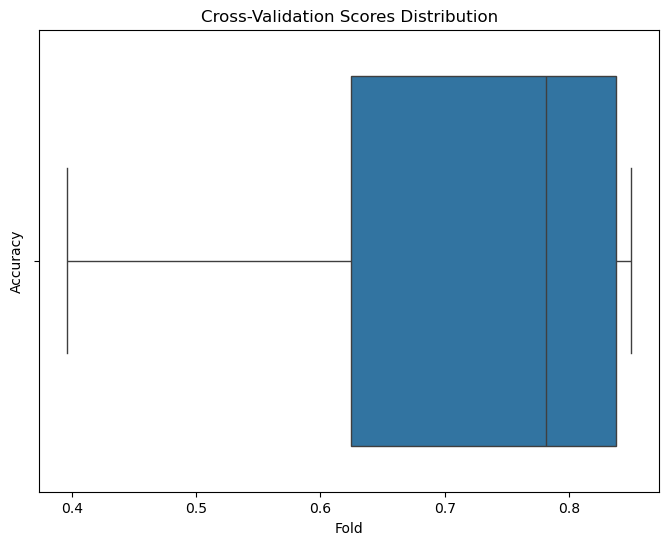

In [83]:
# Plotting cross-validation scores
plt.figure(figsize=(8, 6))
sns.boxplot(x=cv_scores)
plt.title('Cross-Validation Scores Distribution')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.show()

### Analyzing Feature Importance for Each Feature in RandomForest Model

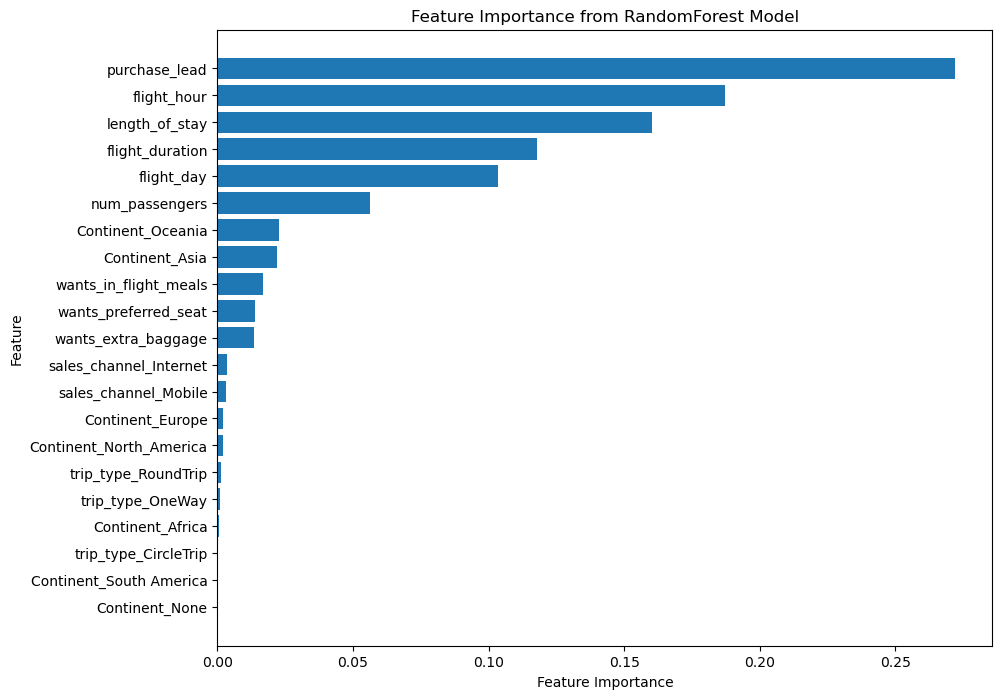

In [75]:
# Extracting feature importances
feature_importances = rf.feature_importances_

# Get the indices that would sort the array in descending order
sorted_indices = feature_importances.argsort()[::1]

# Sort the feature importances in descending order
sorted_feature_importances = feature_importances[sorted_indices]

# Get the corresponding feature names
sorted_feature_names = X.columns[sorted_indices]

# Create a bar plot
plt.figure(figsize=(10, 8))
plt.barh(sorted_feature_names, 
         sorted_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from RandomForest Model')
plt.show()

**Insights from the Feature Importance Analysis of the RandomForest Model:**

**Key Influential Features:**
- The RandomForest Model has identified certain features that significantly influence its predictions. The most prominent contributors include 'purchase_lead,' 'flight_hour,' 'length of stay,' 'flight_duration,' 'flight_day,' and 'num_passengers.'

**Features with Minimal Impact:**
- On the other hand, certain features exhibit comparatively lesser influence on the model's decision-making process. Notably, 'Continent-Africa,' 'trip_type_CircleTrip,' 'Continent_South America,' and 'Continent_None' emerge as features with minimal impact in shaping the model's predictions.

### Utilizing XGBoost Model

In [84]:
# Assuming X_train and y_train are your training data
xgb_model_best = XGBClassifier()
xgb_model_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xgb_model_best.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on Test Set:", accuracy)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy on Test Set: 0.8527
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.99      0.92      8520
           1       0.53      0.04      0.08      1480

    accuracy                           0.85     10000
   macro avg       0.69      0.52      0.50     10000
weighted avg       0.81      0.85      0.80     10000

